In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
from patsy import dmatrix

import causalpy as cp

In [190]:
N = 1000


def inv_logit(x):
    return 1 / (1 + np.exp(-x))


df1 = pd.DataFrame(
    np.random.multivariate_normal([0.5, 1], [[2, 1], [1, 1]], size=N),
    columns=["x1", "x2"],
)
df1["trt"] = np.where(
    -0.5 + 0.25 * df1["x1"] + 0.75 * df1["x2"] + np.random.normal(0, 1, size=N) > 0,
    1,
    0,
)
TREATMENT_EFFECT = 2
df1["outcome"] = (
    4
    + TREATMENT_EFFECT * df1["trt"]
    + df1["x1"]
    + df1["x2"]
    + np.random.normal(0, 1, size=N)
)
df1.head()

,x1,x2,trt,outcome
0,0.192527,1.839369,1,8.484918
1,-0.362518,1.137514,1,6.664834
2,1.454742,1.639615,1,10.032736
3,-0.353850,0.437835,0,5.337335
4,-2.697615,-0.194152,0,-0.372344


/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


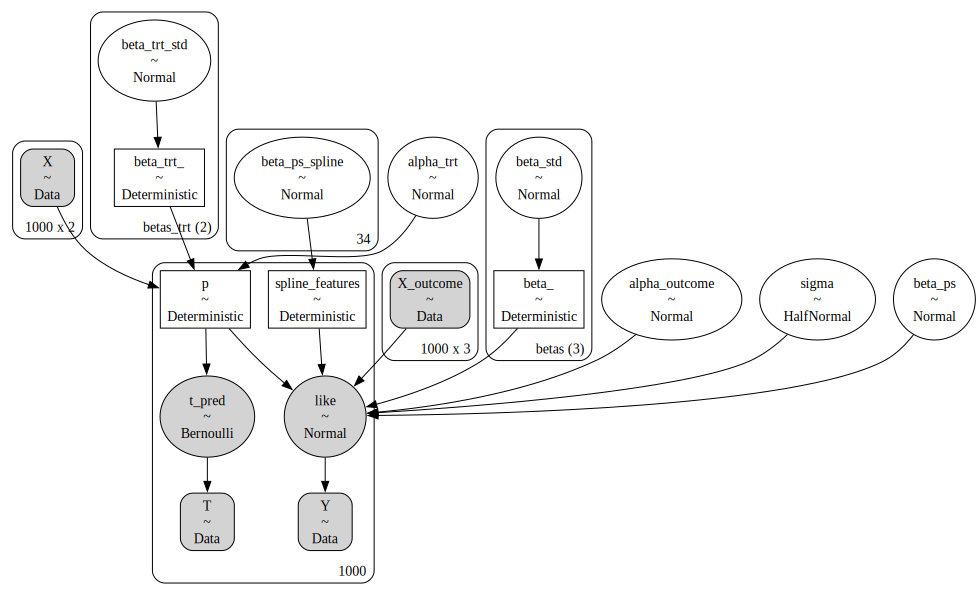

In [ ]:
coords = {
    "betas": ["trt", "x1", "x2"],
    "betas_trt": ["x1", "x2"],
    "obs": range(df1.shape[0]),
}

N = df1.shape[0]
X_trt = df1[["x1", "x2"]].values
X_outcome = df1[["trt", "x1", "x2"]].values
T_data = df1["trt"].values
Y_data = df1["outcome"].values


def make_model(
    X_trt,
    X_outcome,
    T_data,
    Y_data,
    coords,
    priors={
        "beta_": [0, 1],
        "beta_trt": [0, 1],
        "alpha_trt": [0, 1],
        "alpha_outcome": [0, 1],
    },
    noncentred=True,
):
    with pm.Model(coords=coords) as model:
        X_data_trt = pm.Data("X", X_trt)
        X_data_outcome = pm.Data("X_outcome", X_outcome)
        T_data_ = pm.Data("T", T_data, mutable=True)
        Y_data_ = pm.Data("Y", Y_data)

        if noncentred:
            mu_beta_trt, sigma_beta_trt = priors["beta_trt"]
            beta_trt_std = pm.Normal("beta_trt_std", 0, 1, dims="betas_trt")
            beta_trt = pm.Deterministic(
                "beta_trt_",
                mu_beta_trt + sigma_beta_trt * beta_trt_std,
                dims="betas_trt",
            )

            mu_beta, sigma_beta = priors["beta_"]
            beta_std = pm.Normal("beta_std", 0, 1, dims="betas")
            beta = pm.Deterministic(
                "beta_", mu_beta + sigma_beta * beta_std, dims="betas"
            )
        else:
            beta_trt = pm.Normal(
                "beta_trt_",
                priors["beta_trt"][0],
                priors["beta_trt"][1],
                dims="betas_trt",
            )

            beta = pm.Normal(
                "beta_", priors["beta_"][0], priors["beta_"][1], dims="betas"
            )

        beta_ps_spline = pm.Normal("beta_ps_spline", 0, 1, size=34)
        beta_ps = pm.Normal("beta_ps", 0, 1)

        alpha_trt = pm.Normal(
            "alpha_trt", priors["alpha_trt"][0], priors["alpha_trt"][1]
        )
        mu_trt = alpha_trt + pm.math.dot(X_data_trt, beta_trt)
        p = pm.Deterministic("p", pm.math.invlogit(mu_trt))

        pm.Bernoulli("t_pred", p=p, observed=T_data_)

        B = dmatrix(
            "bs(ps, knots=knots, degree=3, include_intercept=True) - 1",
            {"ps": np.linspace(0, 1, X_trt.shape[0]), "knots": np.linspace(0, 1, 30)},
        )
        B_f = np.asarray(B, order="F")
        splines_summed = pm.Deterministic(
            "spline_features", pm.math.dot(B_f, beta_ps_spline.T)
        )

        alpha_outcome = pm.Normal(
            "alpha_outcome", priors["alpha_outcome"][0], priors["alpha_outcome"][1]
        )
        mu_outcome = (
            alpha_outcome
            + pm.math.dot(X_data_outcome, beta)
            + p * splines_summed
            + beta_ps * p
        )
        sigma = pm.HalfNormal("sigma", 1)

        _ = pm.Normal("like", mu_outcome, sigma, observed=Y_data_)

    return model


model = make_model(X_trt, X_outcome, T_data, Y_data, coords)

pm.model_to_graphviz(model)

In [192]:
with model:
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(tune=2000, target_accept=0.95, nuts_sampler="numpyro"))

Sampling: [alpha_outcome, alpha_trt, beta_ps, beta_ps_spline, beta_std, beta_trt_std, like, sigma, t_pred]


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [193]:
az.summary(
    idata, var_names=["alpha_trt", "beta_trt_", "alpha_outcome", "beta_", "beta_ps"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_trt,-0.670,0.118,-0.905,-0.458,0.002,0.001,4153.0,2832.0,1.0
beta_trt_[x1],0.431,0.078,0.294,0.589,0.001,0.001,5725.0,3335.0,1.0
beta_trt_[x2],0.986,0.120,0.758,1.206,0.002,0.001,3313.0,2837.0,1.0
alpha_outcome,3.706,0.193,3.373,4.105,0.005,0.003,1594.0,2353.0,1.0
beta_[trt],1.965,0.079,1.819,2.113,0.001,0.001,6612.0,3216.0,1.0
beta_[x1],0.957,0.049,0.858,1.045,0.001,0.001,2564.0,2855.0,1.0
beta_[x2],0.870,0.093,0.699,1.053,0.002,0.001,2236.0,2097.0,1.0
beta_ps,0.676,0.505,-0.273,1.594,0.012,0.009,1746.0,2265.0,1.0


In [194]:
X_outcome_trt = X_outcome.copy()
X_outcome_trt[:, 0] = 1

X_outcome_ntrt = X_outcome.copy()
X_outcome_ntrt[:, 0] = 0

In [195]:
with pm.do(
    model,
    {"T": np.ones(len(df1), dtype=np.int32), "X_outcome": X_outcome_trt},
    prune_vars=True,
) as treatment_model:
    idata_trt = pm.sample_posterior_predictive(idata, var_names=["like", "p"])

with pm.do(
    model,
    {"T": np.zeros(len(df1), dtype=np.int32), "X_outcome": X_outcome_ntrt},
    prune_vars=True,
) as ntreatment_model:
    idata_ntrt = pm.sample_posterior_predictive(idata, var_names=["like", "p"])

Sampling: [like]


Output()

Sampling: [like]


Output()

In [196]:
idata_trt["posterior_predictive"]["like"].mean()

<xarray.DataArray 'like' ()> Size: 8B
array(7.38106334)

In [197]:
idata_ntrt["posterior_predictive"]["like"].mean()

<xarray.DataArray 'like' ()> Size: 8B
array(5.41605235)

In [198]:
(
    idata_trt["posterior_predictive"]["like"].mean()
    - idata_ntrt["posterior_predictive"]["like"].mean()
)

<xarray.DataArray 'like' ()> Size: 8B
array(1.96501099)

## Nets Example



In [199]:
nets_df = pd.read_csv("../../../causalpy/data/nets_df.csv")
nets_df["trt"] = nets_df["net_num"]
nets_df["outcome"] = nets_df["malaria_risk"]
nets_df

,id,net,net_num,malaria_risk,income,health,household,eligible,temperature,resistance,trt,outcome
0,1,True,1,33,781,56,2,False,21.1,59,1,33
1,2,False,0,42,974,57,4,False,26.5,73,0,42
2,3,False,0,80,502,15,3,False,25.6,65,0,80
3,4,True,1,34,671,20,5,True,21.3,46,1,34
4,5,False,0,44,728,17,5,False,19.2,54,0,44
...,...,...,...,...,...,...,...,...,...,...,...,...
1747,1748,True,1,18,961,27,4,False,22.1,27,1,18
1748,1749,False,0,49,906,49,5,False,30.7,55,0,49
1749,1750,False,0,17,1325,92,2,False,21.4,52,0,17
1750,1751,False,0,46,879,33,6,False,27.4,62,0,46


In [200]:
import statsmodels.formula.api as smf

res = smf.ols(
    "outcome ~ trt + income + temperature + health + household", nets_df
).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     2692.
Date:                Tue, 08 Jul 2025   Prob (F-statistic):               0.00
Time:                        21:57:23   Log-Likelihood:                -5386.7
No. Observations:                1752   AIC:                         1.079e+04
Df Residuals:                    1746   BIC:                         1.082e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      76.2067      0.966     78.906      0.000      74.313      78.101
trt           -10.4370      0.266    -39.163      0.000     -10.960      -9.914
income         -0.0751      0.001    -72.563      0.000      -0.077      -0.073
temperature     1.0058      0.031     32.483      0.000       0.945       1.067
health          0.1483      0.011     13.900      0.000       0.127       0.169
household      -0.0155      0.089     -0.173      0.863      -0.191       0.160
==============================================================================
Omnibus:                       60.116   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.001
Skew:                           0.462   Prob(JB):                     7.68e-15
Kurtosis:                       2.813   Cond. No.                     7.14e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [201]:
res = smf.logit("trt ~ income + temperature + health + household", nets_df).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.632368
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    trt   No. Observations:                 1752
Model:                          Logit   Df Residuals:                     1747
Method:                           MLE   Df Model:                            4
Date:                Tue, 08 Jul 2025   Pseudo R-squ.:                 0.05357
Time:                        21:57:26   Log-Likelihood:                -1107.9
converged:                       True   LL-Null:                       -1170.6
Covariance Type:            nonrobust   LLR p-value:                 3.704e-26
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.8249      0.395     -4.616      0.000      -2.600      -1.050
income          0.0021      0.000      4.923      0.000       0.001       0.003
temperature    -0.0582      0.013     -4.626      0.000      -0.083      -0.034
health          0.0071      0.004      1.649      0.099      -0.001       0.016
household       0.1601      0.036      4.436      0.000       0.089       0.231
===============================================================================
"""

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


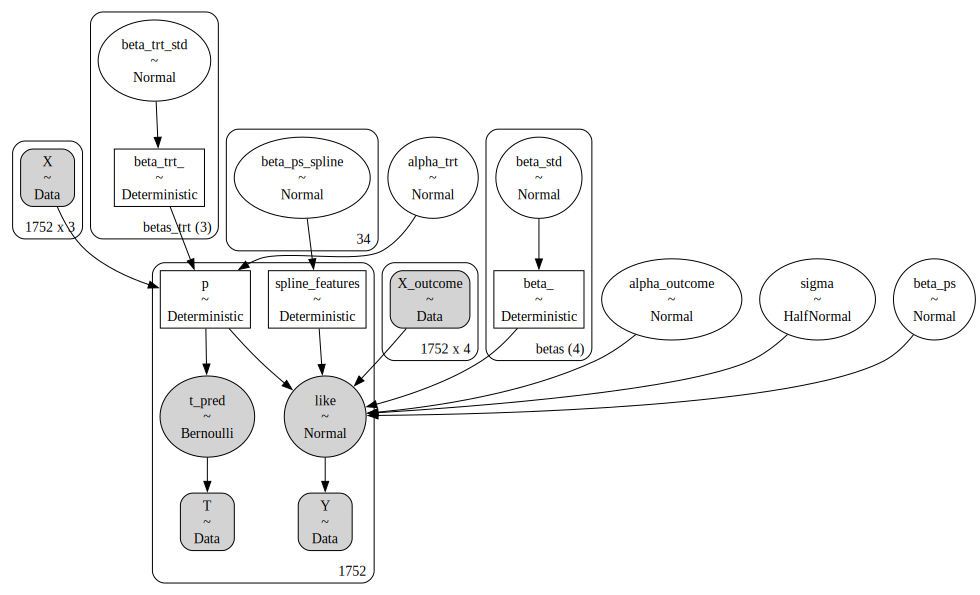

In [202]:
coords = {
    "betas": ["trt", "income", "temperature", "health"],
    "betas_trt": ["income", "temperature", "health"],
    "obs": range(nets_df.shape[0]),
}

N = nets_df.shape[0]
X_trt = nets_df[["income", "temperature", "health"]].values
X_trt = (X_trt - X_trt.mean(axis=0)) / X_trt.std(axis=0)
X_outcome = nets_df[["trt", "income", "temperature", "health"]].values
X_outcome = (X_outcome - X_outcome.mean(axis=0)) / X_outcome.std(axis=0)
T_data = nets_df["trt"].values
X_outcome[:, 0] = T_data
Y_data = nets_df["outcome"].values

priors = {
    "beta_": [0, 1],
    "beta_trt": [0, 1],
    "alpha_trt": [0, 1],
    "alpha_outcome": [40, 10],
}
net_model = make_model(X_trt, X_outcome, T_data, Y_data, coords, priors=priors)

pm.model_to_graphviz(net_model)

In [203]:
with net_model:
    idata_net = pm.sample(tune=2000, target_accept=0.98)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, beta_std, beta_ps_spline, beta_ps, alpha_trt, alpha_outcome, sigma]
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 24 seconds.


In [205]:
az.summary(idata_net, var_names=["alpha_trt", "beta_", "beta_ps", "alpha_outcome"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_trt,-0.483,0.053,-0.579,-0.384,0.001,0.001,5177.0,3056.0,1.0
beta_[trt],-9.862,0.251,-10.348,-9.418,0.003,0.002,6022.0,2892.0,1.0
beta_[income],-13.672,0.211,-14.045,-13.269,0.004,0.003,2854.0,3114.0,1.0
beta_[temperature],4.099,0.140,3.818,4.343,0.002,0.002,3589.0,3081.0,1.0
beta_[health],2.210,0.193,1.858,2.589,0.003,0.002,3387.0,2828.0,1.0
beta_ps,0.161,1.021,-1.786,2.028,0.023,0.016,1997.0,2611.0,1.0
alpha_outcome,39.363,0.432,38.569,40.190,0.010,0.007,2024.0,2499.0,1.0


<Axes: title={'center': 'beta_\ntrt'}>

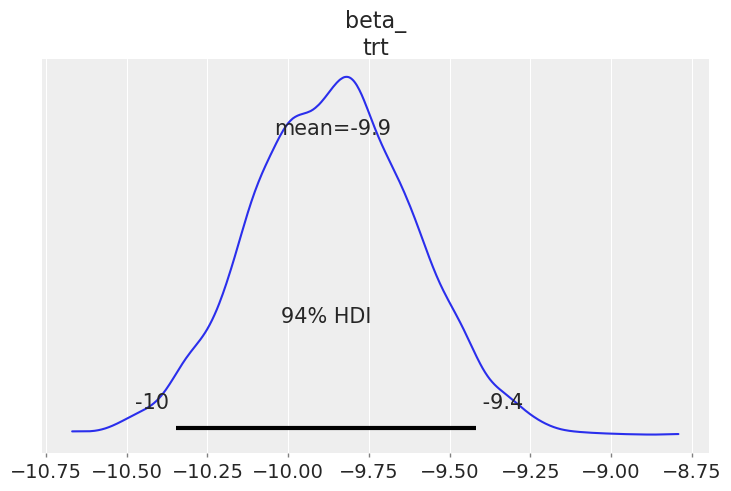

In [208]:
az.plot_posterior(idata_net, var_names=["beta_"], coords={"betas": ["trt"]})

## LaLonde Example

In [209]:
lalonde = pd.read_csv(
    "https://vincentarelbundock.github.io/Rdatasets/csv/MatchIt/lalonde.csv"
)
lalonde[["hispan", "white"]] = pd.get_dummies(lalonde["race"], drop_first=True)
lalonde.dropna(inplace=True)

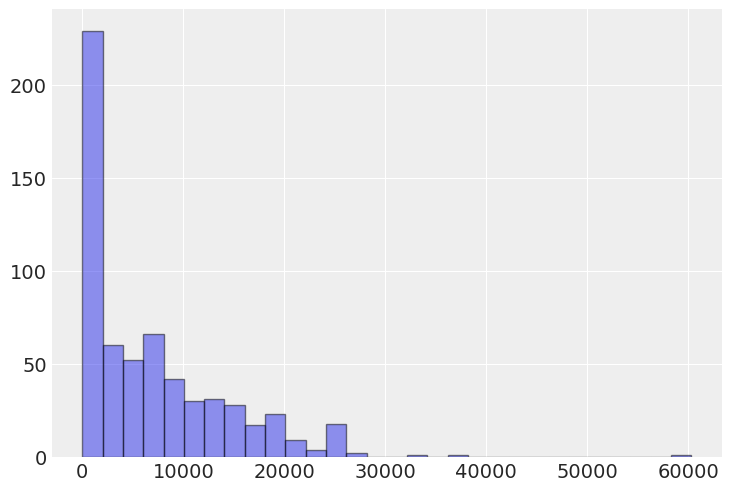

In [210]:
from matplotlib import pyplot as plt

plt.hist(lalonde["re78"], bins=30, alpha=0.5, ec="black");

In [211]:
lalonde.groupby("treat")["re78"].mean()

treat
0    6984.169742
1    6349.143530
Name: re78, dtype: float64

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


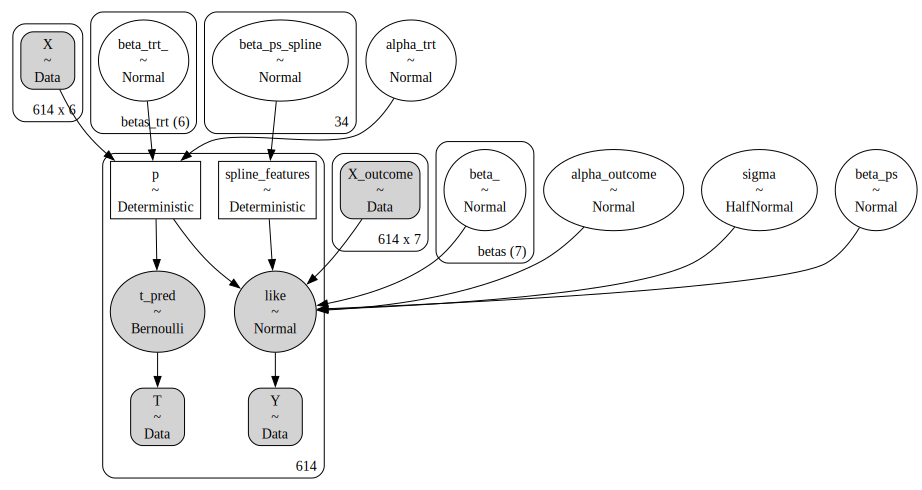

In [212]:
coords = {
    "betas": ["treat", "age", "educ", "hispan", "white", "married", "nodegree"],
    "betas_trt": ["age", "educ", "hispan", "white", "married", "nodegree"],
    "obs": range(lalonde.shape[0]),
}

N = lalonde.shape[0]
X_trt = (
    lalonde[["age", "educ", "hispan", "white", "married", "nodegree"]]
    .astype(np.int32)
    .values
)

X_outcome = (
    lalonde[["treat", "age", "educ", "hispan", "white", "married", "nodegree"]]
    .astype(np.int32)
    .values
)
T_data = lalonde["treat"].values
Y_data = lalonde["re78"].values


priors = {
    "beta_": [0, 4000],
    "beta_trt": [0, 4000],
    "alpha_trt": [0, 1],
    "alpha_outcome": [2000, 500],
}

lalonde_model = make_model(
    X_trt, X_outcome, T_data, Y_data, coords, priors, noncentred=False
)

pm.model_to_graphviz(lalonde_model)

In [213]:
with lalonde_model:
    idata_lalonde = pm.sample(tune=5000, nuts_sampler="numpyro")

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [214]:
az.summary(
    idata_lalonde,
    var_names=["alpha_trt", "beta_trt_", "alpha_outcome", "beta_", "beta_ps"],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_trt,-0.790,0.698,-2.115,0.501,0.013,0.010,2983.0,2748.0,1.0
beta_trt_[age],0.005,0.013,-0.019,0.028,0.000,0.000,5098.0,3089.0,1.0
beta_trt_[educ],0.106,0.051,0.007,0.198,0.001,0.001,3154.0,2689.0,1.0
beta_trt_[hispan],-2.216,0.363,-2.920,-1.560,0.005,0.004,5801.0,2600.0,1.0
beta_trt_[white],-3.190,0.281,-3.707,-2.666,0.004,0.003,6291.0,3060.0,1.0
beta_trt_[married],-0.926,0.275,-1.411,-0.393,0.004,0.003,5715.0,2943.0,1.0
beta_trt_[nodegree],0.596,0.287,0.061,1.128,0.005,0.003,3618.0,3214.0,1.0
alpha_outcome,-1995.540,146.711,-2275.632,-1730.047,2.774,1.963,2796.0,2580.0,1.0
beta_[treat],1149.428,46.173,1064.198,1237.905,0.708,0.500,4265.0,2900.0,1.0
beta_[age],53.599,1.945,49.927,57.131,0.029,0.020,4613.0,3049.0,1.0


In [215]:
X_outcome_trt = X_outcome.copy()
X_outcome_trt[:, 0] = 1
X_outcome_trt = X_outcome_trt.astype(np.int32)

X_outcome_ntrt = X_outcome.copy()
X_outcome_ntrt[:, 0] = 0
X_outcome_ntrt = X_outcome_ntrt.astype(np.int32)


with pm.do(
    lalonde_model,
    {"T": np.ones(len(lalonde), dtype=np.int32), "X_outcome": X_outcome_trt},
    prune_vars=True,
) as treatment_model:
    idata_trt = pm.sample_posterior_predictive(idata_lalonde, var_names=["like", "p"])

with pm.do(
    lalonde_model,
    {"T": np.zeros(len(lalonde), dtype=np.int32), "X_outcome": X_outcome_ntrt},
    prune_vars=True,
) as ntreatment_model:
    idata_ntrt = pm.sample_posterior_predictive(idata_lalonde, var_names=["like", "p"])

Sampling: [like]


Output()

Sampling: [like]


Output()

In [216]:
(
    idata_trt["posterior_predictive"]["like"].mean()
    - idata_ntrt["posterior_predictive"]["like"].mean()
)

<xarray.DataArray 'like' ()> Size: 8B
array(1149.42770137)

In [217]:
res = smf.ols("re78 ~ treat ", lalonde).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9338
Date:                Tue, 08 Jul 2025   Prob (F-statistic):              0.334
Time:                        22:01:26   Log-Likelihood:                -6346.4
No. Observations:                 614   AIC:                         1.270e+04
Df Residuals:                     612   BIC:                         1.271e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6984.1697    360.710     19.362      0.000    6275.791    7692.549
treat       -635.0262    657.137     -0.966      0.334   -1925.544     655.492
==============================================================================
Omnibus:                      209.619   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              775.567
Skew:                           1.567   Prob(JB):                    3.87e-169
Kurtosis:                       7.527   Cond. No.                         2.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [218]:
import statsmodels.formula.api as smf

res = smf.ols(
    "re78 ~ treat + age + educ + hispan + white + married + nodegree", lalonde
).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     6.594
Date:                Tue, 08 Jul 2025   Prob (F-statistic):           1.59e-07
Time:                        22:01:32   Log-Likelihood:                -6324.3
No. Observations:                 614   AIC:                         1.266e+04
Df Residuals:                     606   BIC:                         1.270e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -2352.7506   2540.562     -0.926      0.355   -7342.126    2636.625
hispan[T.True]  2173.6001   1059.746      2.051      0.041      92.380    4254.820
white[T.True]   1538.0720    798.864      1.925      0.055     -30.807    3106.951
treat           1163.9224    811.617      1.434      0.152    -430.001    2757.845
age               55.8953     32.831      1.703      0.089      -8.582     120.372
educ             525.5796    164.381      3.197      0.001     202.753     848.406
married         2136.9467    679.736      3.144      0.002     802.022    3471.871
nodegree         -36.4776    882.377     -0.041      0.967   -1769.367    1696.411
==============================================================================
Omnibus:                      201.275   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              848.900
Skew:                           1.446   Prob(JB):                    4.61e-185
Kurtosis:                       7.982   Cond. No.                         279.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [219]:
df = cp.load_data("nhefs")
df[["age", "race", "trt", "smokeintensity", "smokeyrs", "outcome"]].head()

,age,race,trt,smokeintensity,smokeyrs,outcome
0,42,1,0,30,29,-10.093960
1,36,0,0,20,24,2.604970
2,56,1,0,20,26,9.414486
3,68,1,0,3,53,4.990117
4,40,0,0,20,19,4.989251


In [221]:
coords = {
    "betas": [
        "trt",
        "age",
        "smokeintensity",
        "smokeyrs",
        "wt71",
        "active_1",
        "active_2",
        "education_2",
        "education_3",
        "education_4",
        "education_5",
        "exercise_1",
        "exercise_2",
    ],
    "betas_trt": [
        "age",
        "smokeintensity",
        "smokeyrs",
        "wt71",
        "active_1",
        "active_2",
        "education_2",
        "education_3",
        "education_4",
        "education_5",
        "exercise_1",
        "exercise_2",
    ],
    "obs": range(df.shape[0]),
}

N = df.shape[0]
X_trt = df[
    [
        "age",
        "smokeintensity",
        "smokeyrs",
        "wt71",
        "active_1",
        "active_2",
        "education_2",
        "education_3",
        "education_4",
        "education_5",
        "exercise_1",
        "exercise_2",
    ]
]
X_trt = (X_trt - X_trt.mean(axis=0)) / X_trt.std(axis=0)
X_outcome = df[
    [
        "trt",
        "age",
        "smokeintensity",
        "smokeyrs",
        "wt71",
        "active_1",
        "active_2",
        "education_2",
        "education_3",
        "education_4",
        "education_5",
        "exercise_1",
        "exercise_2",
    ]
]
X_outcome = (X_outcome - X_outcome.mean(axis=0)) / X_outcome.std(axis=0)
T_data = df["trt"].values
X_outcome["trt"] = T_data
Y_data = df["outcome"].values

new_model = make_model(X_trt, X_outcome, T_data, Y_data, coords)
new_model

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


   beta_trt_std ~ Normal(0, 1)
       beta_std ~ Normal(0, 1)
 beta_ps_spline ~ Normal(0, 1)
        beta_ps ~ Normal(0, 1)
      alpha_trt ~ Normal(0, 1)
  alpha_outcome ~ Normal(0, 1)
          sigma ~ HalfNormal(0, 1)
      beta_trt_ ~ Deterministic(f(beta_trt_std))
          beta_ ~ Deterministic(f(beta_std))
              p ~ Deterministic(f(alpha_trt, beta_trt_std))
spline_features ~ Deterministic(f(beta_ps_spline))
         t_pred ~ Bernoulli(p)
           like ~ Normal(f(beta_ps, alpha_outcome, beta_ps_spline, alpha_trt, beta_std, beta_trt_std), sigma)

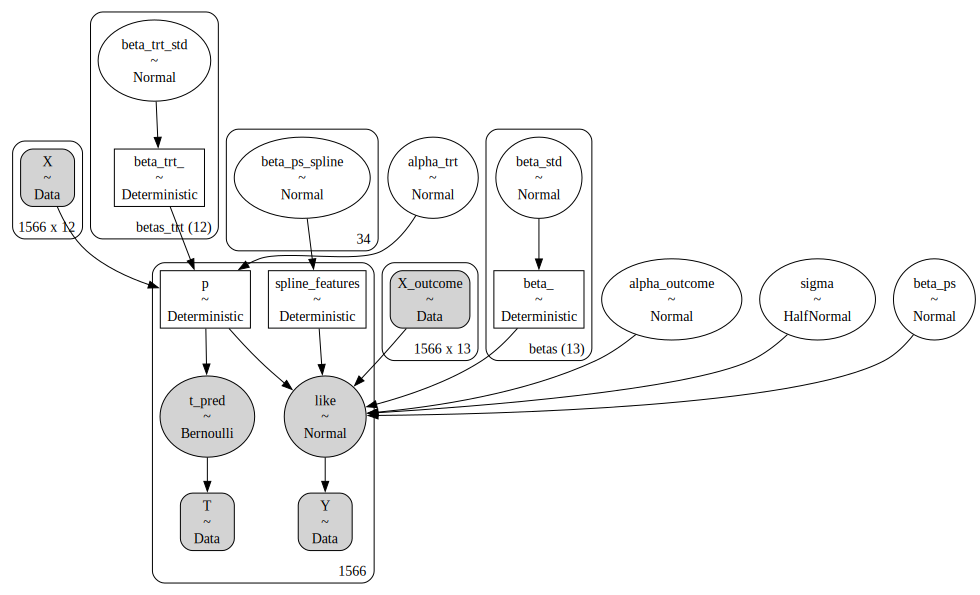

In [222]:
pm.model_to_graphviz(new_model)

In [223]:
with new_model:
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(tune=3000, target_accept=0.99, nuts_sampler="numpyro"))

Sampling: [alpha_outcome, alpha_trt, beta_ps, beta_ps_spline, beta_std, beta_trt_std, like, sigma, t_pred]


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [224]:
az.summary(
    idata, var_names=["alpha_trt", "beta_trt_", "alpha_outcome", "beta_", "beta_ps"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_trt,-1.119,0.060,-1.229,-1.003,0.001,0.001,4882.0,3067.0,1.0
beta_trt_[age],0.465,0.115,0.246,0.669,0.002,0.002,2590.0,2592.0,1.0
beta_trt_[smokeintensity],-0.219,0.065,-0.344,-0.101,0.001,0.001,4568.0,3134.0,1.0
beta_trt_[smokeyrs],-0.205,0.113,-0.419,-0.002,0.002,0.002,2371.0,2522.0,1.0
beta_trt_[wt71],0.155,0.059,0.043,0.265,0.001,0.001,4374.0,3482.0,1.0
beta_trt_[active_1],-0.006,0.063,-0.120,0.112,0.001,0.001,3675.0,3079.0,1.0
beta_trt_[active_2],0.045,0.062,-0.072,0.160,0.001,0.001,3916.0,3241.0,1.0
beta_trt_[education_2],-0.051,0.078,-0.200,0.095,0.001,0.001,2909.0,3004.0,1.0
beta_trt_[education_3],0.040,0.084,-0.123,0.190,0.002,0.001,2528.0,2889.0,1.0
beta_trt_[education_4],0.038,0.071,-0.094,0.177,0.001,0.001,2978.0,2914.0,1.0


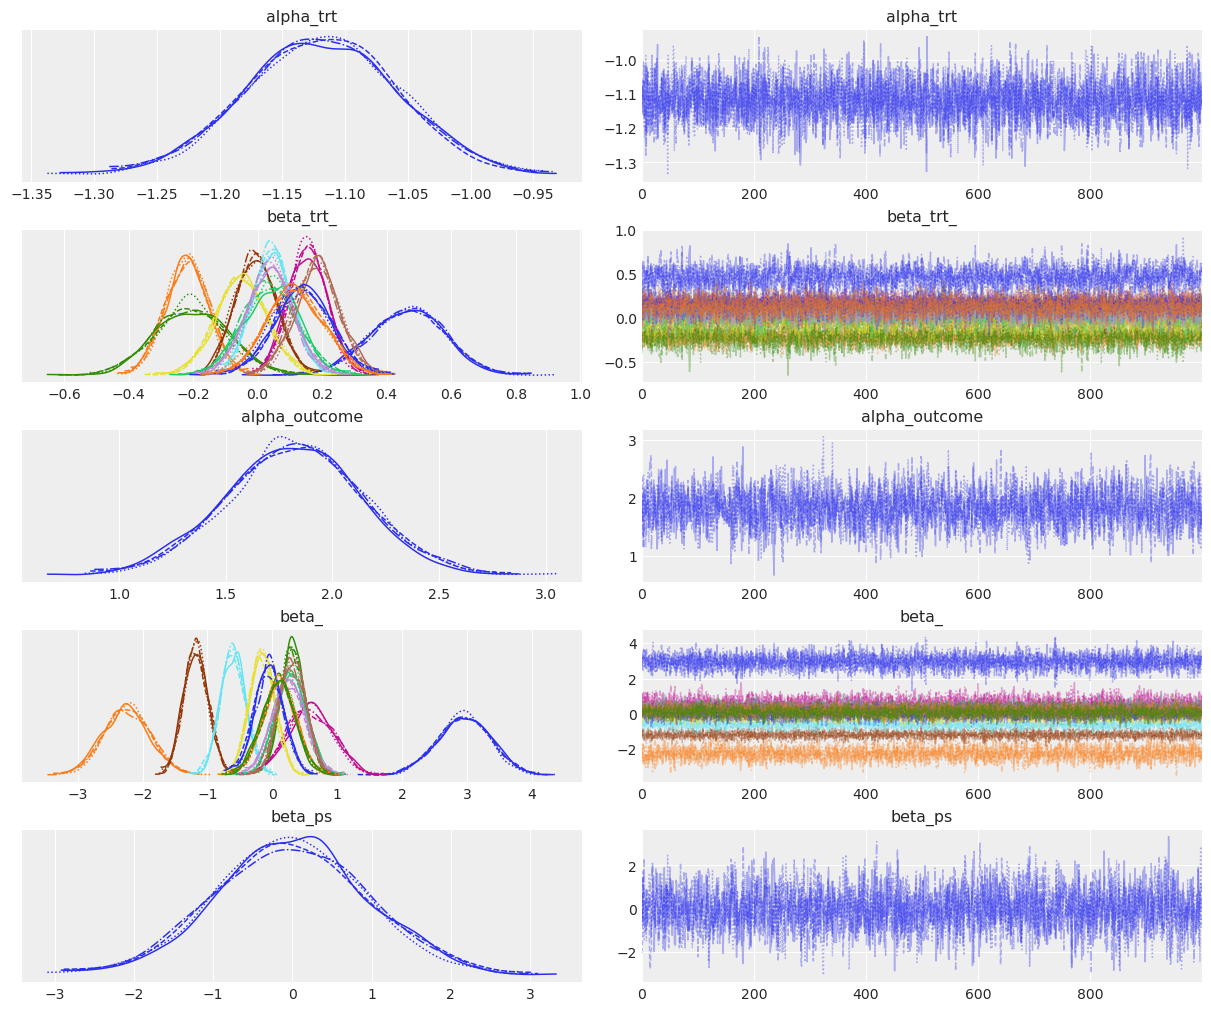

In [225]:
az.plot_trace(
    idata, var_names=["alpha_trt", "beta_trt_", "alpha_outcome", "beta_", "beta_ps"]
);